In [23]:
import os
from dotenv import load_dotenv
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, text

In [20]:
load_dotenv()
URI = os.getenv('URI_DB')
data_dir = os.getenv('DATA_DIR')

variable_desc = {
    'FRUIT_inv' : 'Lack of fruit consumption',
    'PNEUMO' : 'Lack of pneumonia vaccination',
    'FLUSHOT' : 'Lack of flu vaccination',
    'VEGE' : 'Lack of vegetable consumption',
    'RFBING' : 'Whether a binge drinker',
    'SMOKER' : 'Smoker category',
    'HTCARE' : 'Lack of healthcare coverage',
    'SLEPTIM' : 'Sleep amount',
    'RFDRHV' : 'Whether a heavy drinker',
    'RFSMOK' : 'Whether a current smoker',
    'TOTINDA' : 'Lack of exercise',
    'FRUIT' : 'Lack of fruit consumption'
}

## Set up virtual environment

`requirements.txt` includes the packages used for this app and their corresponding versions

`runtime.txt` has been set up to match the local python version

In windows, create and activate virtual environment py running:

`python -m venv venv`

`.\venv\Scripts\activate`

Then, install the required packages and check the list:

`pip install -r requirements.txt`

`pip freeze`

## Set up Procfile

I set up two Procfiles, one for the Heroku deployment and one for local:

`Procfile` and `Procfile.windows`

Heroku deployment:

`web: gunicorn --pythonpath flask_app app:app`

local deployment:

`web: python flask_app/app.py runserver 127.0.0.1:5111`

and run command:

`heroku local web -f Procfile.windows`

## Logic for adding scripts to the main page (Project Menrva dashboard)

There are many ways of doing this, but since the dataset is very large, I'm going to 

### Generate visualizations for the dashboard as json files (stored in /data directory)

These are altair interactive visualizations. Refer to the data notebook for more details on how these were generated. 

The generated Altair visualizations are saved as json format in `flask_app/data/*/*.json`

### Integrate them into the dashboard

Integration is achieved by the following javascript:

`<script>
    var spec = {{ the_chart | safe }};
    vegaEmbed("#vis", spec);
</script>`

## Integration of DB instances to the project

I learn about creating/managing/deploying DB instances to my project in this section.

### readme file from https://github.com/bjo/altair-flask-demo/

### SQL database
The application uses an SQL database and makes queries against it to obtain the wells to visualize. Two options are presented: SQLite for only local deployment or PostgreSQL for either local or deployment to Heroku. Instructions for both are found below. Note, you can skip the last step of each and jump to deployment by running `make all`, as running `make all` takes care of creating the database once `.env` has been configured properly. By default, `create-db` truncates the records in the database to comply with Heroku's free tier limit. However, you can prevent truncation by setting the environmental variable `TRUNCATE` to an empty string. E.g., `make TRUNCATE="" all`.

#### SQLite
1. Create your own `.env`: `cp .env.template .env`
1. Assign `URI_DB` to `sqlite:///data/wells.db`
1. Run `make create-db` or `make TRUNCATE="" create-db` (no truncation)

#### Heroku managed PostgreSQL
1. Create a [Heroku](https://heroku.com) account
1. Install the [Heroku CLI](https://devcenter.heroku.com/articles/heroku-cli#download-and-install)
1. Create your own `.env`: `cp .env.template .env`
1. Create a Heroku app: `heroku create`
1. In your `.env`, set `APP_NAME` to your application's name form the previous step
1. Run `make create-db`

### Other databases
You can use a database that is not managed by Heroku. For example, your own Postgres server you have setup yourself or a fully managed one by a different provider. If you want to go the latter route, consider [ElephantSQL](https://www.elephantsql.com). The free tier lets you have a database up to 20 MB. Whatever you decide, the instructions are similiar, run `make create-db`. However, before you run `make create-db`, make sure you add `export OTHER_DB=true` to your `.env`.

Two things to consider:

1. If you are deploying to Heroku, make sure you set `APP_NAME` as `make create-db` will set the `URI_DB` environmental variable on Heroku. If you don't set `APP_NAME`, you will need to make sure you set `URI_DB` on Heroku yourself.

1. If you are using a different RDBMS, e.g., MySQL, you'll need to make sure you have the appropriate Python driver installed in your virtual environment.

### Use of Postgres managed instance at ElephantSQL (free tier, up to 20MB)

Set up an account at:

https://customer.elephantsql.com/instance

and start a new Postgres instance - project_menrva

`bin/init_db` file - particularly necessary for setting up DB on heroku

In [ ]:
%%bash
#!/bin/bash
#
# Create a Heroku managed Postgres database if it doesn't exist or clear/reset
# an existing one. If URI_DB is an SQLite database, remove the file if it
# exists. If you are not using either SQLite or Heroku managed Postgres
# database, make sure to either unset APP_NAME or set OTHER_DB to true.

check_db() {
    echo "Checking if database already exists"
    heroku addons --app $APP_NAME | grep -q heroku-postgresql
}

add_db() {
    heroku addons:create --app $APP_NAME heroku-postgresql:hobby-dev

    echo "Setting URI_DB in .env"
    URI_DB=$(heroku config:get DATABASE_URL --app $APP_NAME | sed "s/postgres/postgresql/g")
    sed -i "/^#/!s\URI_DB=.*\URI_DB=$URI_DB\g" .env
    grep -q "URI_DB=$URI_DB" .env || \
    echo "Could not replace URI_DB in .env." \
    "You will need to manually set this value in your .env."

    heroku config:set URI_DB=$URI_DB
}

reset_db() {
    DB_HEROKU=$(heroku pg:info --app $APP_NAME | grep "postgresql.+")
    heroku pg:reset $DB_HEROKU --confirm $APP_NAME
}

set_config() {
    if [[ -n $APP_NAME ]]; then
    echo "Setting URI_DB environmental variable on Heroku"
    URI_DB=$(echo $URI_DB | sed "s/postgres:/postgresql:/g")
    heroku --app $APP_NAME config:set URI_DB=$URI_DB
    fi
}

source .env

if [[ ${URI_DB::6} == "sqlite" ]]; then
    rm -f data/wells.db
elif [[ $OTHER_DB == true ]]; then
    echo "Not using SQLite or Heroku managed Postgres database"
    set_config
else
    (check_db && reset_db) || add_db
fi


## Creation of DB tables that match our visualization

This DB will store statistical information about the tested hypotheses, and serve them up with user query

In [25]:
n_samp = 100000
COVDB_data = []
for dep_variable in variable_desc:
    sub_df = pd.read_csv(data_dir + 'COVDB/' + dep_variable + '_' + str(n_samp) + '_COVDB.csv')
    sub_df.columns = ['beta', 'absTstat', 'covVar']
    sub_df['depVar'] = dep_variable
    COVDB_data.append(sub_df)
    
COVDB_df = pd.concat(COVDB_data, axis = 0)
COVDB_df['pValue'] = scipy.stats.norm.sf(COVDB_df['absTstat'])*2*COVDB_df.shape[0]
COVDB_df['significant'] = COVDB_df['pValue'] < 0.01
COVDB_df.head()

,beta,absTstat,covVar,depVar,pValue,significant
0,0.186646,111.950901,_AGEG5YR,FRUIT_inv,0.000000e+00,True
1,0.121296,96.765607,_SEX,FRUIT_inv,0.000000e+00,True
2,0.114761,80.887249,_EDUCAG,FRUIT_inv,0.000000e+00,True
3,-0.045411,36.284861,year,FRUIT_inv,4.346002e-286,True
4,0.049747,32.475410,_INCOMG,FRUIT_inv,3.676911e-229,True


(array([73., 36., 25.,  7.,  5.,  2.,  2.,  3.,  1.,  1.]),
 array([1.00428612e-01, 2.88405269e+01, 5.75806252e+01, 8.63207235e+01,
        1.15060822e+02, 1.43800920e+02, 1.72541018e+02, 2.01281117e+02,
        2.30021215e+02, 2.58761313e+02, 2.87501411e+02]),
 <BarContainer object of 10 artists>)

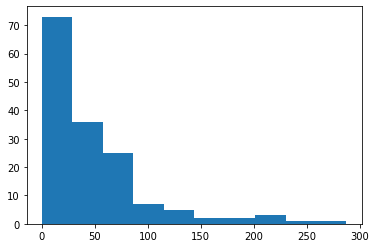

In [14]:
import matplotlib.pyplot as plt
plt.hist(COVDB_df['absTstat'])

In [57]:
def create_cov_table(engine, n_samp):
    DB_data = []
    table_name = 'COVDB'
    for dep_variable in variable_desc:
        sub_df = pd.read_csv(data_dir + table_name + '/' + dep_variable + '_' + str(n_samp) + '_' + table_name + '.csv')
        sub_df.columns = ['beta', 'absTstat', 'covVar']
        sub_df['depVar'] = dep_variable
        DB_data.append(sub_df)

    DB_df = pd.concat(DB_data, axis=0)
    scaled_pvals = scipy.stats.norm.sf(DB_df['absTstat']) * 2 * DB_df.shape[0]
    DB_df['pValue'] = [min(pval, 1) for pval in scaled_pvals]
    DB_df['significant'] = DB_df['pValue'] < 0.01
    DB_df.to_sql(table_name, engine, if_exists='replace')
    return table_name

create_cov_table(engine, n_samp)

'COVDB'

In [30]:
def create_geo_table(engine, n_samp):
    DB_data = []
    table_name = 'GEODB'
    for dep_variable in variable_desc:
        sub_df = pd.read_csv(data_dir + table_name + '/' + dep_variable + '_' + str(n_samp) + '_' + table_name + '.csv')
        first_year = sub_df.columns[2].split('_')[-1]
        last_year = sub_df.columns[4].split('_')[-1]
        sub_df.columns = ['stateId', 'stateAbbr', 'depVarFirst', 'residFirst', 'depVarLast', 'residLast', 'depVarChng', 'residChng']
        sub_df['depVar'] = dep_variable
        sub_df['firstYear'] = int(first_year)
        sub_df['lastYear'] = int(last_year)
        DB_data.append(sub_df)

    DB_df = pd.concat(DB_data, axis=0)
    DB_df.to_sql(table_name, engine, if_exists='replace')
    return table_name

create_geo_table(engine, n_samp)

'GEODB'

In [56]:
def create_corr_table(engine, n_samp):
    DB_data = []
    table_name = 'CORRDB'
    for dep_variable in variable_desc:
        sub_df = pd.read_csv(data_dir + table_name + '/' + dep_variable + '_' + str(n_samp) + '_' + table_name + '.csv')
        sub_df.columns = ['beta', 'absTstat', 'pValue', 'indepVar']
        sub_df['depVar'] = dep_variable
        DB_data.append(sub_df)

    DB_df = pd.concat(DB_data, axis=0)
    scaled_pvals = DB_df['pValue']*DB_df.shape[0]
    DB_df['pValue'] = [min(pval, 1) for pval in scaled_pvals]
    DB_df['significant'] = DB_df['pValue'] < 0.01
    DB_df.to_sql(table_name, engine, if_exists='replace')
    return table_name

create_corr_table(engine, n_samp)

'CORRDB'

In [58]:
os.path.exists(data_dir + table_name + '/' + dep_variable + '_' + str(n_samp) + '_' + table_name + '.csv')

True

In [59]:
def create_ts_table(engine, n_samp):
    DB_data = []
    table_name = 'TSDB'
    for dep_variable in variable_desc:
        if os.path.exists(data_dir + table_name + '/' + dep_variable + '_' + str(n_samp) + '_' + table_name + '.csv'):
            sub_df = pd.read_csv(data_dir + table_name + '/' + dep_variable + '_' + str(n_samp) + '_' + table_name + '.csv')
            sub_df['depVar'] = dep_variable
            DB_data.append(sub_df)

    DB_df = pd.concat(DB_data, axis=0)
    DB_df.to_sql(table_name, engine, if_exists='replace')
    return table_name

create_ts_table(engine, n_samp)

'TSDB'

## Loading DB data to serve up to the dashboard

Now, the necessary DB has been inserted into the ElephantSQL DB instance.

In [17]:
db_name = 'COVDB'
dep_variable = 'TOTINDA'
# Test an example query
query = text(
        f"""
        SELECT "covVar", "absTstat", "pValue", "significant"
        FROM "{db_name}"
        WHERE "depVar" = '{dep_variable}';
        """.format(db_name, dep_variable)
    )

with engine.connect() as conn:
    results = (
        conn
        .execute(query)
        .fetchall()
    )
    
results

[('_RFHLTH', 197.75205651138057, 0.0, True),
 ('_EDUCAG', 153.39019725589276, 0.0, True),
 ('_INCOMG', 99.1044364438562, 0.0, True),
 ('_AGEG5YR', 75.89394540785176, 0.0, True),
 ('_BMICAT', 67.53653602803799, 0.0, True),
 ('_SEX', 51.31120174533276, 0.0, True),
 ('_RACE', 30.835998510607848, 1.3378035504349697e-206, True),
 ('_CHLDCNT', 18.51642165094018, 2.3594807649461543e-74, True),
 ('_ASTHM', 16.17866010830352, 1.1056128450064012e-56, True),
 ('_RFHYPE', 14.59099123736979, 4.967853777670366e-46, True),
 ('_HISPANC', 4.781855586574146, 0.0002692108818294784, True),
 ('year', 4.234446185677199, 0.003551292432561642, True),
 ('_RFCHOL', 3.9591567578248696, 0.011658303042412301, False)]

### Creating DB queries that respond to user request, and integrating them into the dashboard

In [38]:
db_name = 'GEODB'
var = 'TOTINDA'
query1 = text(
    f"""
        SELECT "stateAbbr", "residChng", "depVarFirst", "firstYear", "depVarLast", "lastYear"
        FROM "{db_name}"
        WHERE "depVar" = '{var}'
        ORDER BY "depVarLast" DESC
        LIMIT 5;
    """.format(db_name, var)
)
query2 = text(
    f"""
        SELECT "stateAbbr", "residChng", "depVarFirst", "firstYear", "depVarLast", "lastYear"
        FROM "{db_name}"
        WHERE "depVar" = '{var}'
        ORDER BY "depVarLast" ASC
        LIMIT 5;
    """.format(db_name, var)
)
with db_engine.connect() as conn:
    results = (
        conn
        .execute(query1)
        .fetchall()
    ) + (
        conn
        .execute(query2)
        .fetchall()
    )

In [39]:
results

[('CO', -0.0179431611950639, 1.2057783018867925, 2000, 1.1670711974110033, 2020),
 ('DC', -0.0156665858840532, 1.2109617373319546, 2000, 1.168192219679634, 2020),
 ('HI', -0.0787292389311619, 1.2287800425920292, 2000, 1.1729611384783798, 2020),
 ('UT', 0.0398726544467379, 1.1772870662460568, 2000, 1.175705794947994, 2020),
 ('VT', -0.0489089655665335, 1.2235710672736468, 2000, 1.17759900990099, 2020),
 ('PR', -0.4697519631903127, 1.5835814547001277, 2000, 1.424793388429752, 2020),
 ('AR', 0.0155911616971072, 1.3041894353369765, 2000, 1.3377742946708464, 2020),
 ('MS', -0.1541143718141001, 1.3545981772990887, 2000, 1.3304020100502512, 2020),
 ('KY', -0.2932018444851269, 1.4465531677365335, 2000, 1.326467559217302, 2020),
 ('OK', -0.112871563064589, 1.3482587064676617, 2000, 1.311216429699842, 2020)]

In [42]:
db_name = 'CORRDB'
query = text(
    f"""
        SELECT "indepVar", "beta", "pValue", "significant"
        FROM "{db_name}"
        WHERE "depVar" = '{var}'
        ORDER BY "pValue"
        LIMIT 10;
    """.format(db_name, var)
)
with db_engine.connect() as conn:
    results = (
        conn
            .execute(query)
            .fetchall()
    )
    
results

[('aintpi', 2.3424136354140885, 2.965290218609929e-32, True),
 ('anecpi', 1.3113032626536734, 5.000616317578353e-31, True),
 ('afcgapi', 1.884555056927564, 1.1025600324609293e-29, True),
 ('cbeer', 0.0031224483846474, 1.9675041069368788e-29, True),
 ('aincstat3', 0.2958835858680658, 8.898112324439898e-29, True),
 ('asanpi', 3.2727994852800277, 1.3857356094079066e-28, True),
 ('ainctot2', 0.1835003291879938, 7.888069976807385e-28, True),
 ('acorrpi', 3.177211817951861, 1.0844409673741213e-27, True),
 ('cwine', 0.0007137603986744, 6.263853137001089e-27, True),
 ('apolpi', 1.70134870651998, 6.574240737425774e-27, True)]

In [55]:
"{0:.4g}".format(results[0][2])

'2.965e-32'